In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

In [27]:
import os

# List all files in the /kaggle/input directory to confirm dataset path and file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"Directory: {dirname}")
    for filename in filenames:
        print(f" - {filename}")

Directory: /kaggle/input
Directory: /kaggle/input/nasa-turbofan-engine-degradation-simulation-data
 - RUL_FD002.txt
 - test_FD003.txt
 - Damage Propagation Modeling.pdf
 - readme.txt
 - train_FD003.txt
 - test_FD004.txt
 - train_FD004.txt
 - test_FD002.txt
 - train_FD001.txt
 - train_FD002.txt
 - RUL_FD001.txt
 - RUL_FD004.txt
 - RUL_FD003.txt
 - test_FD001.txt


In [110]:
import pandas as pd

# Define the file paths (make sure these paths are correct)
train_file_path = '/kaggle/input/nasa-turbofan-engine-degradation-simulation-data/train_FD001.txt'
test_file_path = '/kaggle/input/nasa-turbofan-engine-degradation-simulation-data/test_FD001.txt'
rul_file_path = '/kaggle/input/nasa-turbofan-engine-degradation-simulation-data/RUL_FD001.txt'

# Read the training data
train_data = pd.read_csv(train_file_path, sep=' ', header=None)  # Adjust sep if necessary
# Read the test data
test_data = pd.read_csv(test_file_path, sep=' ', header=None)  # Adjust sep if necessary
# Read the RUL data
rul_data = pd.read_csv(rul_file_path, sep=' ', header=None)  # Adjust sep if necessary

# Check the first few rows of the training data
print(train_data.head())


   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]


In [112]:
# Check the shape of the DataFrame
print("Shape of training data:", train_data.shape)

# Display data types of each column
print("\nData types:\n", train_data.dtypes)

# Check for missing values
print("\nMissing values:\n", train_data.isnull().sum())


Shape of training data: (20631, 28)

Data types:
 0       int64
1       int64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21      int64
22      int64
23    float64
24    float64
25    float64
26    float64
27    float64
dtype: object

Missing values:
 0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64


In [113]:
# Drop columns with all missing values
train_data.drop(columns=[train_data.columns[26], train_data.columns[27]], inplace=True)


In [115]:
print(train_data.describe())


                 0             1             2             3        4   \
count  20631.000000  20631.000000  20631.000000  20631.000000  20631.0   
mean      51.506568    108.807862     -0.000009      0.000002    100.0   
std       29.227633     68.880990      0.002187      0.000293      0.0   
min        1.000000      1.000000     -0.008700     -0.000600    100.0   
25%       26.000000     52.000000     -0.001500     -0.000200    100.0   
50%       52.000000    104.000000      0.000000      0.000000    100.0   
75%       77.000000    156.000000      0.001500      0.000300    100.0   
max      100.000000    362.000000      0.008700      0.000600    100.0   

             5             6             7             8             9   ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min      518.

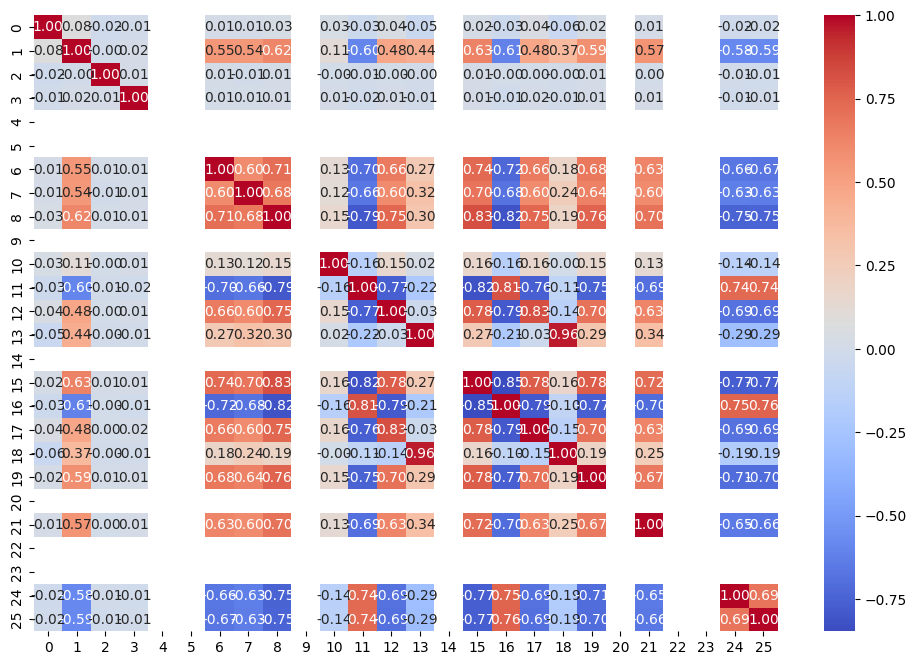

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [118]:
# Check the data types of the columns in train_data
print(train_data.dtypes)

# Check the data types of the index in rul_data
print(rul_data.index.dtype)


unit_number                   float64
time_in_cycles                float64
operational_setting_1         float64
operational_setting_2         float64
operational_setting_3         float64
sensor_measurement_1          float64
sensor_measurement_2          float64
sensor_measurement_3          float64
sensor_measurement_4          float64
sensor_measurement_5          float64
sensor_measurement_6          float64
sensor_measurement_7          float64
sensor_measurement_8          float64
sensor_measurement_9          float64
sensor_measurement_10         float64
sensor_measurement_11         float64
sensor_measurement_12         float64
sensor_measurement_13         float64
sensor_measurement_14         float64
sensor_measurement_15           int64
sensor_measurement_16           int64
sensor_measurement_17         float64
sensor_measurement_18         float64
sensor_measurement_19         float64
sensor_measurement_20         float64
sensor_measurement_21         float64
cumulative_o

In [120]:
# Display the first few rows and columns of rul_data
print(rul_data.head())
print(rul_data.columns)


   index  RUL
0    112  NaN
1     98  NaN
2     69  NaN
3     82  NaN
4     91  NaN
Index(['index', 'RUL'], dtype='object')


In [122]:
import pandas as pd

# Load the training data using the updated sep parameter
train_data = pd.read_csv('/kaggle/input/nasa-turbofan-engine-degradation-simulation-data/train_FD001.txt', 
                          sep='\s+', 
                          header=None)

# Load the RUL data
rul_data = pd.read_csv('/kaggle/input/nasa-turbofan-engine-degradation-simulation-data/RUL_FD001.txt', 
                       header=None, 
                       names=['RUL'])

# Add unit numbers to train_data
num_units = 100  # Adjust this based on your knowledge of the dataset
train_data['unit_number'] = train_data.index // (train_data.shape[0] // num_units)

# Reset the index of rul_data and add unit numbers
rul_data['unit_number'] = rul_data.index // 20  # Adjust based on the specific number of cycles per unit

# Check the first few rows of train_data and rul_data to confirm unit_number
print("Train Data Sample:")
print(train_data[['unit_number', 0]])  # Display unit number and first column of train data

print("\nRUL Data Sample:")
print(rul_data.head())  # Display the RUL data

# Merge the dataframes on unit_number
train_data = train_data.merge(rul_data[['unit_number', 'RUL']], on='unit_number', how='left')

# Check for NaN values in RUL after merging
print("\nAfter merging:")
print(train_data[['unit_number', 'RUL']].head())

# Calculate RUL based on time_in_cycles if RUL is present
if 'RUL' in train_data.columns:
    train_data['RUL'] = train_data['RUL'] - train_data[0]  # Substitute 0 with the actual column index for time_in_cycles
else:
    print("RUL column not found in merged train_data")

# Drop any rows with NaN values that resulted from lagging
train_data.dropna(inplace=True)

# Display the updated training data
print("\nUpdated Training Data:")
print(train_data.head())


Train Data Sample:
       unit_number    0
0                0    1
1                0    1
2                0    1
3                0    1
4                0    1
...            ...  ...
20626          100  100
20627          100  100
20628          100  100
20629          100  100
20630          100  100

[20631 rows x 2 columns]

RUL Data Sample:
   RUL  unit_number
0  112            0
1   98            0
2   69            0
3   82            0
4   91            0

After merging:
   unit_number    RUL
0            0  112.0
1            0   98.0
2            0   69.0
3            0   82.0
4            0   91.0

Updated Training Data:
   0  1       2       3      4       5       6       7       8      9  ...  \
0  1  1 -0.0007 -0.0004  100.0  518.67  641.82  1589.7  1400.6  14.62  ...   
1  1  1 -0.0007 -0.0004  100.0  518.67  641.82  1589.7  1400.6  14.62  ...   
2  1  1 -0.0007 -0.0004  100.0  518.67  641.82  1589.7  1400.6  14.62  ...   
3  1  1 -0.0007 -0.0004  100.0  518.67  641.8

In [124]:
from sklearn.preprocessing import StandardScaler

# Choose the scaler
scaler = StandardScaler()

# List of features to scale (excluding non-numeric and target columns)
features_to_scale = train_data.columns.difference(['unit_number', 'RUL', 'cumulative_operating_time'])

# Fit and transform the scaler
train_data[features_to_scale] = scaler.fit_transform(train_data[features_to_scale])

# Display the first few rows to see the scaled features
print(train_data.head())


          0        1         2         3    4    5         6        7  \
0 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
1 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
2 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
3 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
4 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   

          8             9  ...        18       19            20        21  \
0 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
1 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
2 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
3 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
4 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   

    22   23        24        25  unit_number    RUL  
0  0.0  0.0  0.981333  0.834564            0

In [125]:
# Display the first few rows to verify the new features
print(train_data.head())


          0        1         2         3    4    5         6        7  \
0 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
1 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
2 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
3 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   
4 -1.367177 -1.58638 -0.349304 -1.483154  0.0  0.0 -1.325363  0.21779   

          8             9  ...        18       19            20        21  \
0 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
1 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
2 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
3 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   
4 -0.500746 -3.552714e-15  ... -0.396446 -0.21146 -1.387779e-17 -0.376903   

    22   23        24        25  unit_number    RUL  
0  0.0  0.0  0.981333  0.834564            0

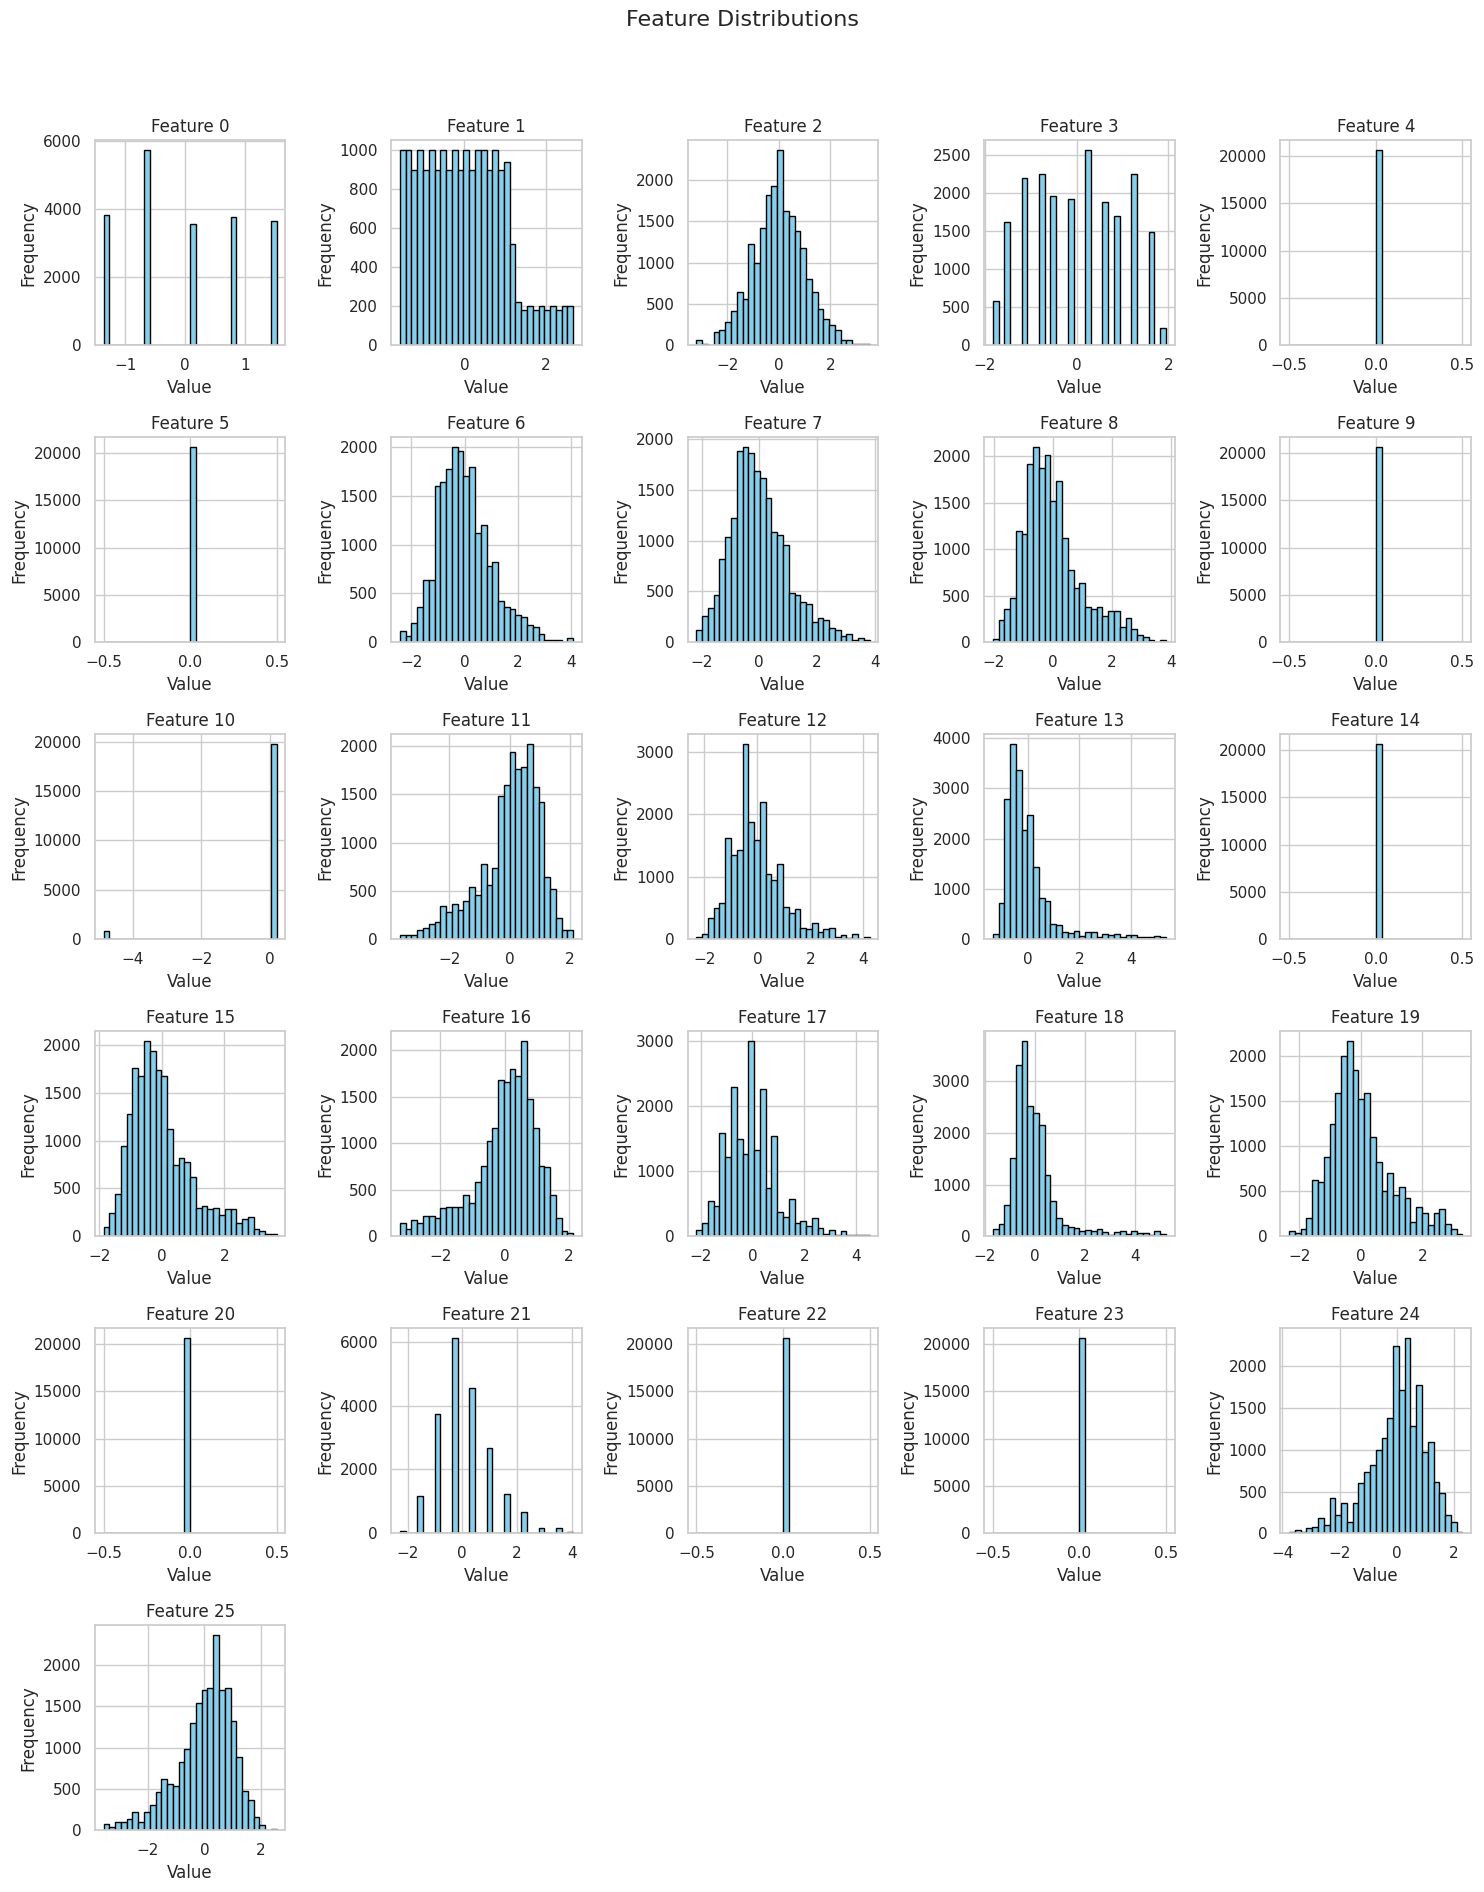

In [128]:
import matplotlib.pyplot as plt

# Define features to scale
features_to_scale = train_data.columns[:-2]  # Exclude 'unit_number' and 'RUL'

# Create subplots
n_cols = 5  # Number of columns in the plot
n_rows = (len(features_to_scale) + n_cols - 1) // n_cols  # Calculate number of rows needed

plt.figure(figsize=(15, n_rows * 3))
for i, feature in enumerate(features_to_scale):
    plt.subplot(n_rows, n_cols, i + 1)  # Create subplots
    train_data[feature].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Feature {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()  # Adjust the layout
plt.suptitle('Feature Distributions', fontsize=16, y=1.05)  # Add a title to the entire figure
plt.show()


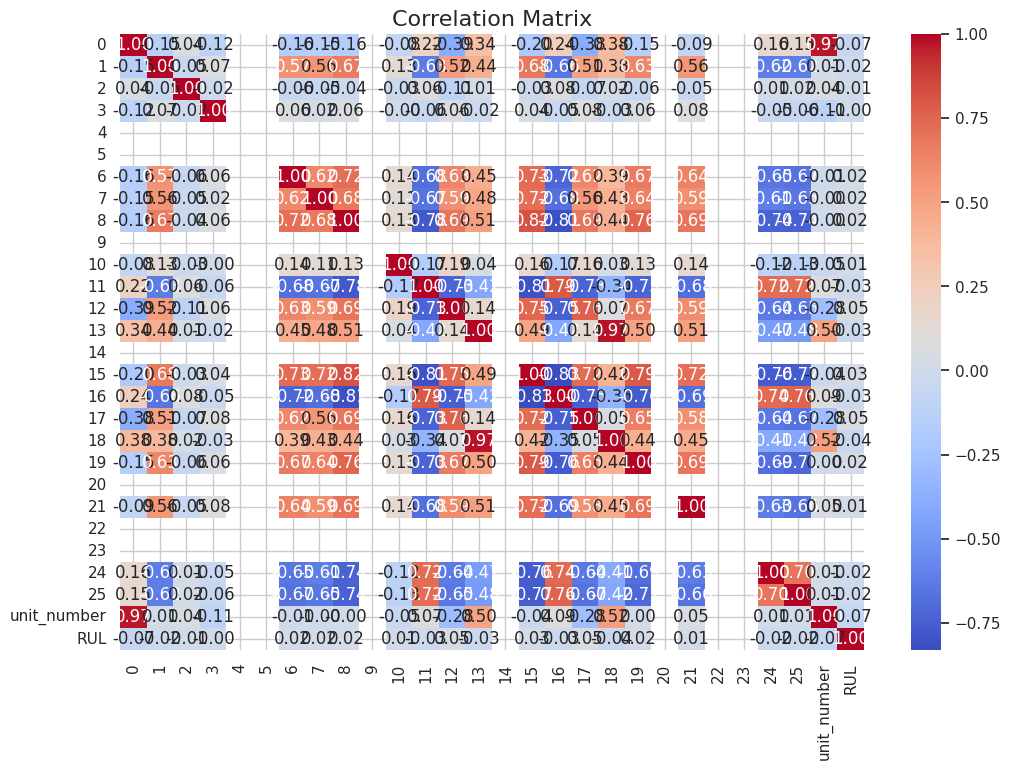

In [143]:

correlation_matrix = train_data.corr()
# print(correlation_matrix['RUL'].sort_values(ascending=False))

# Plot correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

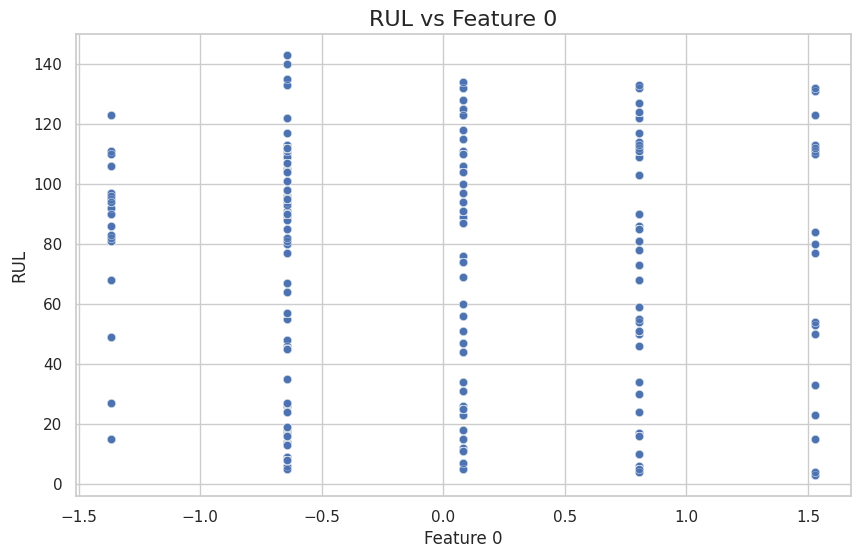

In [137]:
# Feture 0 vs RUL
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x=train_data[0], y='RUL', alpha=0.5)  # Using index 0
plt.title('RUL vs Feature 0', fontsize=16)
plt.xlabel('Feature 0')
plt.ylabel('RUL')
plt.show()

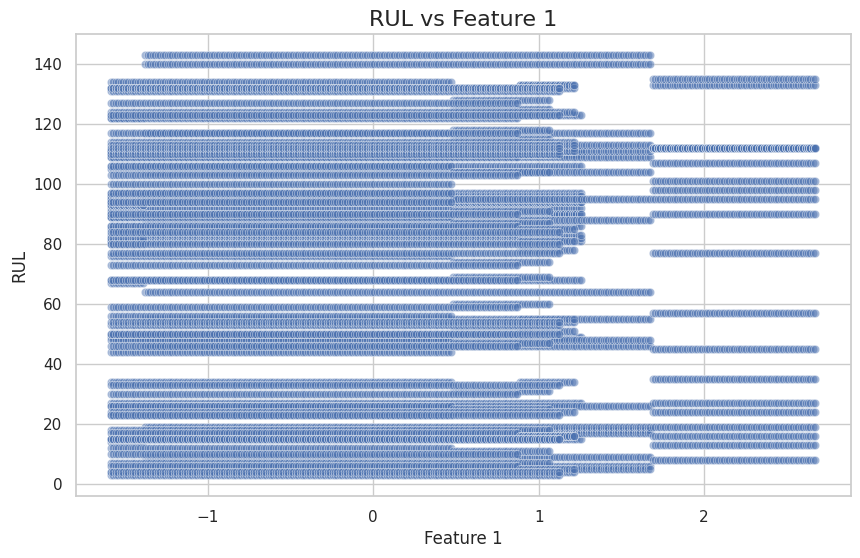

In [138]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x=train_data[1], y='RUL', alpha=0.5)  # Using index 1
plt.title('RUL vs Feature 1', fontsize=16)  # Update title
plt.xlabel('Feature 1')  # Update label
plt.ylabel('RUL')
plt.show()

In [147]:
selected_features = [0, 1, 2, 'unit_number']  # Replace with actual feature names you want to use
X = train_data[selected_features]
y = train_data['RUL']


In [148]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Check the shapes of the resulting sets
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')



X_train shape: (16480, 4), y_train shape: (16480,)
X_test shape: (4120, 4), y_test shape: (4120,)


***Model Building using Random Forest***

In [150]:
# Convert column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

# Check the data types of the features
print(X_train.dtypes)

# Now try fitting the model again
model.fit(X_train, y_train)


0              float64
1              float64
2              float64
unit_number      int64
dtype: object


RandomForestRegressor(random_state=42)

In [151]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')


Mean Squared Error: 1897.74
Mean Absolute Error: 37.54


****Visualizing Actual vs. Predicted Values****

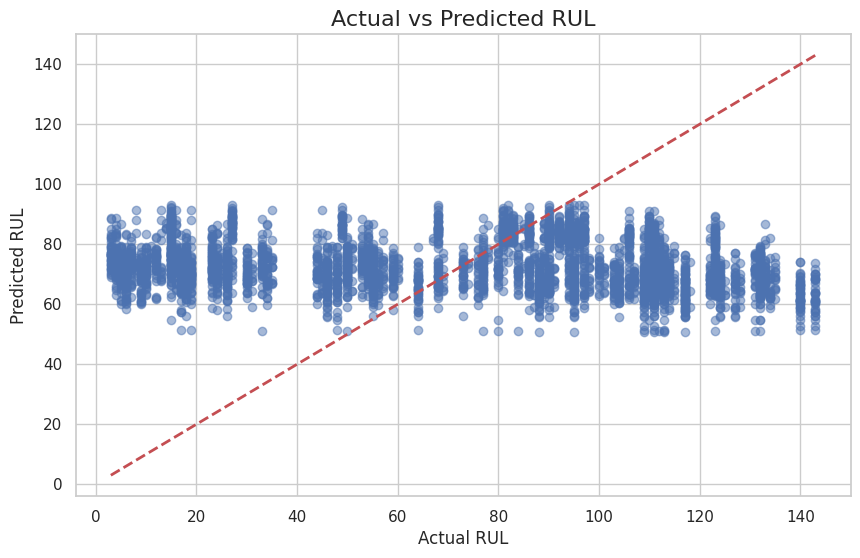

In [155]:


# Make predictions
y_pred = model.predict(X_test)

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.title('Actual vs Predicted RUL', fontsize=16)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.show()


**Analyze the Distribution of Errors:**

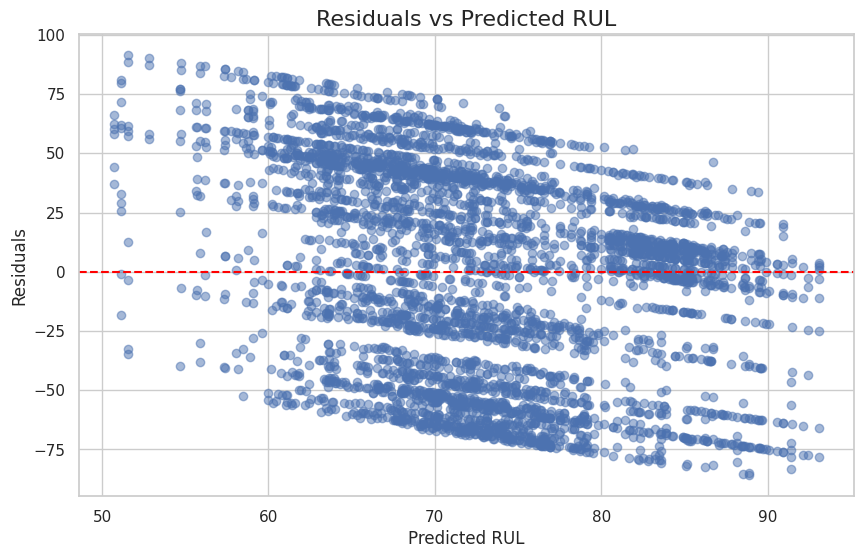

In [153]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted RUL', fontsize=16)
plt.xlabel('Predicted RUL')
plt.ylabel('Residuals')
plt.show()


****Feture Importnace****

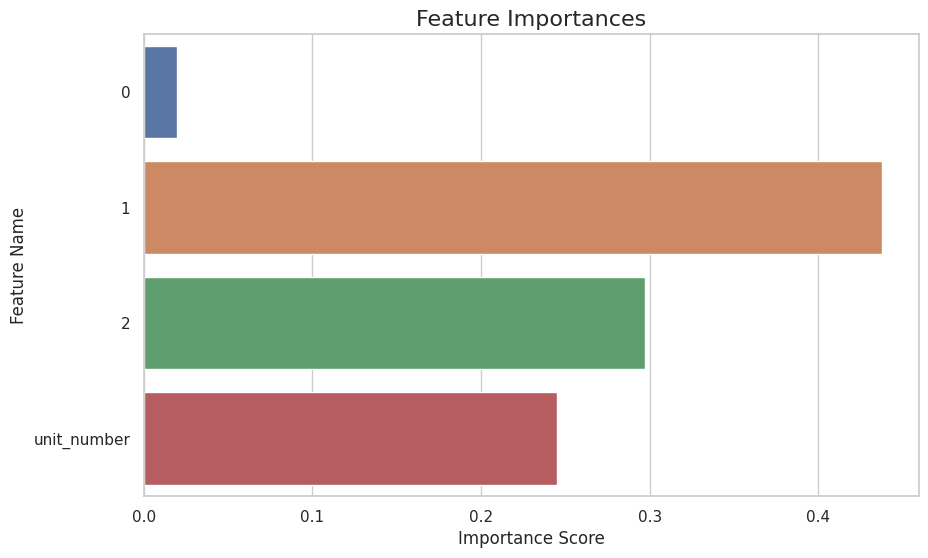

In [154]:
# Get feature importances
importances = model.feature_importances_
feature_names = X_train.columns  # Assuming X_train is a DataFrame

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.show()
